# TODO

1. Retreive train scaler
     1. inverse_scale(X_tr_scaled)
     2. fit_transform() on train_segments
     3. transform() on validation segments
2. Coordinate file locations and file reads with project.

In [116]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut
import pickle

# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

In [2]:
def get_model():
#     kwargs = {'iterations':2000, 'loss_function':'MAE', 'boosting_type':'Plain'}
#     selected_model = CatBoostRegressor(**kwargs) 
    kwargs = {"criterion": "mae", "max_depth": 5, "n_estimators": 50, "n_jobs":-1}
    selected_model = RandomForestRegressor(**kwargs)
    
    return selected_model    

In [3]:
exp2 = pd.read_csv('data/exp2.csv', index_col=0)
exp2.sort_values(by='score').head()

x_tr_scaled = pd.read_csv('data/X_tr_scaled.csv', index_col=0)
print(x_tr_scaled.shape)
x_tr_scaled.head()

y_tr = pd.read_csv('data/y_tr.csv', index_col=0)
print(y_tr.shape)
y_tr.head()

segment_df = pd.read_csv('segment_df.csv', index_col=0)
print(segment_df.shape)
segment_df.head()

(4194, 138)
(4194, 1)
(4194, 2)


,quake_id,y_train
0,0,1.430797
1,0,1.391499
2,0,1.353196
3,0,1.313798
4,0,1.274400


In [4]:
def create_quake_df(segment_df):
    quake_gb = segment_df.groupby('quake_id')

    quake_summary = {}
    for quake_id, quake in quake_gb:
        time_min = quake['y_train'].min()
        time_max = quake['y_train'].max()
        quake_duration = time_max-time_min
        num_segments = len(quake)
        segment_idxes = quake.index
        quake_summary[int(quake_id)] = [quake_id, time_min, time_max, quake_duration, num_segments, segment_idxes]

    quake_df = pd.DataFrame(quake_summary).T
    quake_df.columns = ['quake_id', 'time_min','time_max','quake_duration','num_segments','segment_idxes']
    
    return quake_df

def plot_segment_residual(segment_df, target='y_train', set_ax2_ylim=True):
    fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
    ax1.plot(segment_df[target])
    ax1.set_ylabel(target)
    ax1.set_xlabel("Segment #")

    ax2 = ax1.twinx() 
    ax2.plot( segment_df['validation_segment_pred'], color='r')
    ax2.set_ylabel('y_pred')
    
    # Force y_pred to use the same ylim as target
    if set_ax2_ylim:

        ax2.set_ylim(ax1.set_ylim())
    plt.show()

In [23]:
segment_df.head()

,quake_id,y_train,validation_segment_pred,validation_segment_residual
0,0,1.430797,NaN,NaN
1,0,1.391499,NaN,NaN
2,0,1.353196,NaN,NaN
3,0,1.313798,NaN,NaN
4,0,1.274400,NaN,NaN


In [5]:
quake_df = create_quake_df(segment_df)
quake_df

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,..."
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,..."
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,..."
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930..."
5,5,0.0276957,8.0545,8.0268,207,"Int64Index([1250, 1251, 1252, 1253, 1254, 1255..."
6,6,0.0334984,7.0473,7.0138,181,"Int64Index([1457, 1458, 1459, 1460, 1461, 1462..."
7,7,0.0102978,16.1032,16.0929,414,"Int64Index([1638, 1639, 1640, 1641, 1642, 1643..."
8,8,0.00649738,7.8769,7.8704,203,"Int64Index([2052, 2053, 2054, 2055, 2056, 2057..."
9,9,0.0206955,9.6052,9.5845,247,"Int64Index([2255, 2256, 2257, 2258, 2259, 2260..."


## Inverse Scale All Training Data

In [6]:
## 1. Retreive scale_params.pickle
## 2. inverse scale x_tr_scaled back to x_tr

# scale_params = pickle.load('scale_params.pickle')
# x_tr = scaler.inverse_transformn(x_tr_scaled)

In [7]:
group_kfold = LeaveOneGroupOut()

fold_splitter = group_kfold.split(x_tr_scaled,y_tr,segment_df['quake_id'])

train_errors = []
validation_errors = []

for quake_id, (train_index, valid_index) in enumerate(fold_splitter):
    if quake_id in [0,16]: # 37 and 48 segments for these quakes
        train_errors.append(np.NaN)
        validation_errors.append(np.NaN)
        continue 

    print('Validation Earthquake:', quake_id,end="   ")

    train_signal, validation_signal = x_tr_scaled.iloc[train_index], x_tr_scaled.iloc[valid_index]
## -- Only using scaled data from entire training at the moment.  Not Robust.
#     # Rescale data using only OOF segments
#     train_signal = scaler.fit_transform(train_signal)
#     validation_signal = scaler.transform(validation_signal)  

    train_quaketime, validation_quaketime = y_tr.iloc[train_index], y_tr.iloc[valid_index]
                
    selected_model = get_model()
    selected_model.fit(train_signal, train_quaketime)
    
    train_error = mean_absolute_error(selected_model.predict(train_signal), train_quaketime)

    validation_segment_pred = selected_model.predict(validation_signal)
    segment_df.loc[valid_index,'validation_segment_pred'] = validation_segment_pred
    
    validation_error = mean_absolute_error(validation_segment_pred, validation_quaketime)

    print('train_error: {0:.2f} \t validation_error: {1:.2f} '.format(train_error, validation_error))
    
    train_errors.append(train_error)
    validation_errors.append(validation_error)

Validation Earthquake: 1   train_error: 1.91 	 validation_error: 1.56 
Validation Earthquake: 2   train_error: 1.80 	 validation_error: 3.00 
Validation Earthquake: 3   train_error: 1.91 	 validation_error: 1.45 
Validation Earthquake: 4   train_error: 1.86 	 validation_error: 2.27 
Validation Earthquake: 5   train_error: 1.86 	 validation_error: 2.43 
Validation Earthquake: 6   train_error: 1.85 	 validation_error: 2.58 
Validation Earthquake: 7   train_error: 1.69 	 validation_error: 3.84 
Validation Earthquake: 8   train_error: 1.85 	 validation_error: 2.62 
Validation Earthquake: 9   train_error: 1.93 	 validation_error: 1.08 
Validation Earthquake: 10   train_error: 1.91 	 validation_error: 1.44 
Validation Earthquake: 11   train_error: 1.92 	 validation_error: 1.32 
Validation Earthquake: 12   train_error: 1.91 	 validation_error: 1.54 
Validation Earthquake: 13   train_error: 1.89 	 validation_error: 1.80 
Validation Earthquake: 14   train_error: 1.76 	 validation_error: 3.44 
V

In [188]:
errors_df = pd.DataFrame({'train_error':train_errors, 'validation_error':validation_errors})
errors_df.head()

,train_error,validation_error
0,NaN,NaN
1,1.907613,1.555371
2,1.800314,3.000788
3,1.912141,1.450656
4,1.861470,2.265184


Text(0.5, 0, 'quake_id')

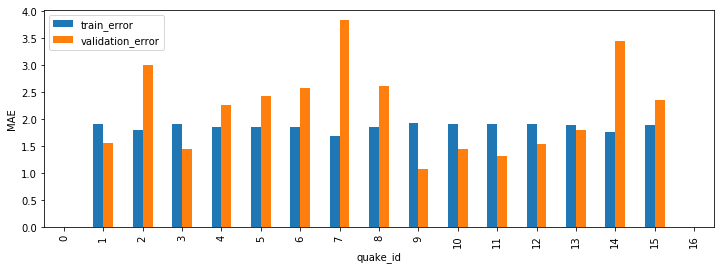

In [19]:
ax = errors_df[['train_error','validation_error']].plot(kind='bar', figsize=(12,4))
ax.set_ylabel('MAE')
ax.set_xlabel('quake_id')

Excluding predictions from quake_id's 0 and 16 due to the small number of responses.  
Quakes 2, 7, and 14 are the longest quakes and the ones with the highest validation error.

In [127]:
quake_df.head()

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,..."
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,..."
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,..."
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930..."


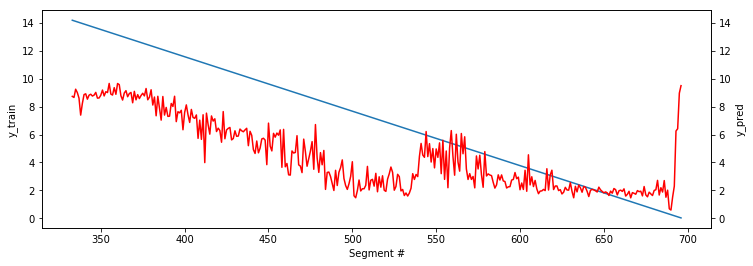

In [175]:
plot_segment_residual(segment_df.loc[quake_df.loc[2,'segment_idxes']])

Something odd is happening on segments it begins predicting large TTF values despite the fact the the quake hasn't occured yet.  It happens in all quake segments

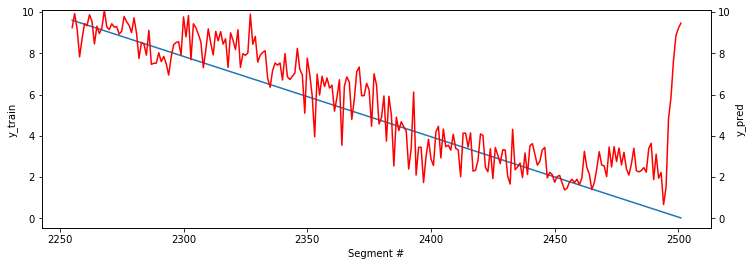

In [179]:
plot_segment_residual(segment_df.loc[quake_df.loc[9,'segment_idxes']])

In [180]:
quake_residuals = pd.concat([quake_df,errors_df], axis=1)
quake_residuals.head()

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_error
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8...",NaN,NaN
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,...",1.907613,1.555371
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,...",1.800314,3.000788
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,...",1.912141,1.450656
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930...",1.861470,2.265184


In [130]:
# from sklearn.linear_model import LinearRegression

# q = quake_residuals.dropna()

# reg = LinearRegression()
# reg.fit(q[['quake_duration']], q['validation_error'])

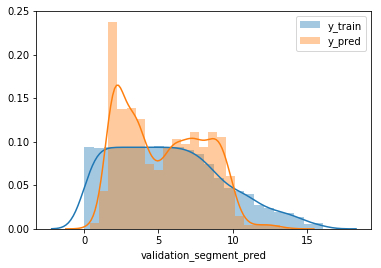

In [184]:
# Drop any rows without 'validation_segment_pred'
pred_hist = segment_df[['y_train','validation_segment_pred']].dropna()

plt.figure()
sns.distplot(pred_hist['y_train'], label='y_train', rug=False)
sns.distplot(pred_hist['validation_segment_pred'], label='y_pred', rug=False)
plt.legend()

There is a conspicuous absence of predictions with low TTF values

# Zoom in on a SubSegment

Use `segment_idxes` field of quake_df to select the a specific quake, or any contiguous time period

In [43]:
quake_num = 8
quake_df.loc[quake_num,'segment_idxes']

Int64Index([2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061,
            ...
            2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254],
           dtype='int64', length=203)

In [149]:
sub_segment = segment_df.iloc[quake_df.loc[quake_num,'segment_idxes']]
sub_segment.head()

,quake_id,y_train,validation_segment_pred,validation_segment_residual,validation_segment_residual_2,validation_segment_residual_3,validation_segment_pred2,validation_segment_pred3,y_train_cut,validation_segment_residual_8,validation_segment_pred8,validation_segment_residual_50,validation_segment_pred50
2052,8,7.876899,9.921739,2.044840,4.969842,6.235614,8.913440,8.881211,"(5.372, 8.055]",6.235614,8.881211,6.235614,8.881211
2053,8,7.838597,9.609852,1.771255,1.908047,3.903646,9.765795,9.145577,"(5.372, 8.055]",3.903646,9.145577,3.903646,9.145577
2054,8,7.799198,8.844353,1.045155,1.408205,1.620416,9.227102,9.458648,"(5.372, 8.055]",1.620416,9.458648,1.620416,9.458648
2055,8,7.760896,8.256943,0.496047,0.770601,1.104152,8.550648,8.903716,"(5.372, 8.055]",1.104152,8.903716,1.104152,8.903716
2056,8,7.721597,8.861872,1.140275,0.818161,0.893826,8.559407,8.654389,"(5.372, 8.055]",0.893826,8.654389,0.893826,8.654389


#  Predictions and Residuals

One advantage of using a continuous interval of time for the training set is that its possible to denoise the predictions (and hopefully cancel noise) by taking the Moving Average of the predictions.  In order to spot anomalies, I've experimented with large window size and will look for anti-monotonicity in the predictions.

In [166]:
segment_df['validation_segment_residual_2'] = segment_df.rolling(window=2)['validation_segment_residual'].mean()
segment_df['validation_segment_residual_50'] = segment_df.rolling(window=50)['validation_segment_residual'].mean()

In [167]:
segment_df['validation_segment_pred2'] = segment_df.rolling(window=2)['validation_segment_pred'].mean()
segment_df['validation_segment_pred50'] = segment_df.rolling(window=50)['validation_segment_pred'].mean()

## Predictions

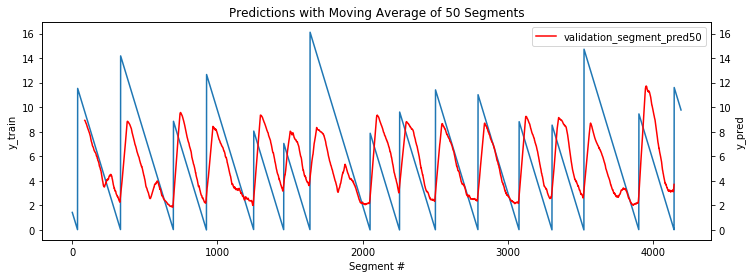

In [187]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")
ax1.set_title('Predictions with Moving Average of 50 Segments')

ax2 = ax1.twinx() 
ax2.plot( segment_df['validation_segment_pred50'], color='r')
ax2.set_ylabel('y_pred')

ax2.set_ylim(ax1.set_ylim())

plt.legend()
plt.show()

Quakes 1, 2, 7, and 15 have a noticeable double sign change on the first derivative of the predicted values, even with a large Moving Average window size of 50.

## Residuals

Mean Absolute Error is the scoring metric, so take the absolute value of the residuals

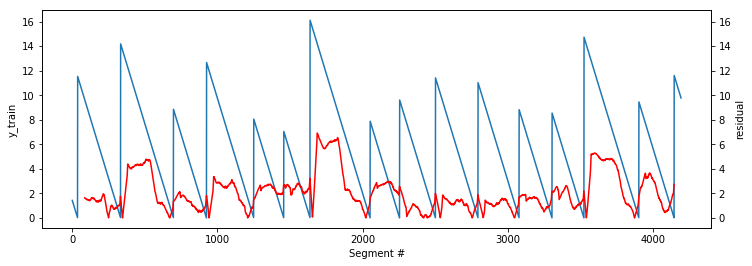

In [185]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( np.abs(segment_df['validation_segment_residual_50']), color='r')
ax2.set_ylabel('residual')

# Force y_pred to use the same ylim as target
# ax1.set_ylim(ax2.set_ylim())
ax2.set_ylim(ax1.set_ylim())
plt.show()

Even if there are slow quakes in the test set, it may be worthwhile to downweight segments from longer quakes when we train or stack our models.

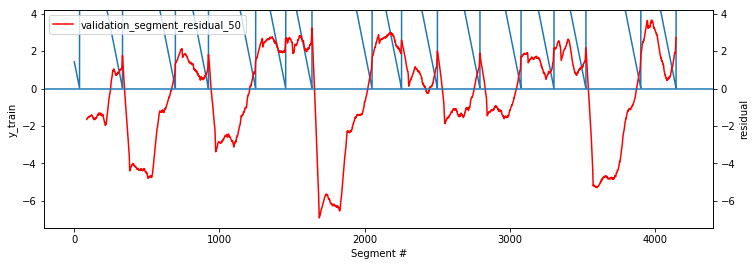

In [186]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( segment_df['validation_segment_residual_50'], color='r')
ax2.set_ylabel('residual')

# Force y_pred to use the same ylim as target
ax1.set_ylim(ax2.set_ylim())

plt.axhline(y=0)
plt.legend()
plt.show()

The pattern of underestimating the large TTF values and overestimating the small TTF values becomes more obvious when the the sign of the error is kept.

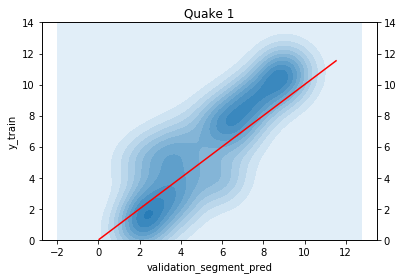

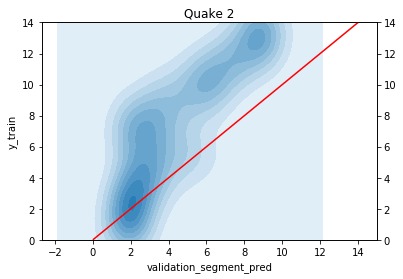

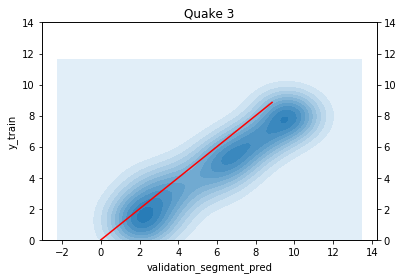

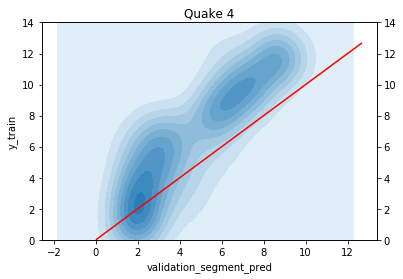

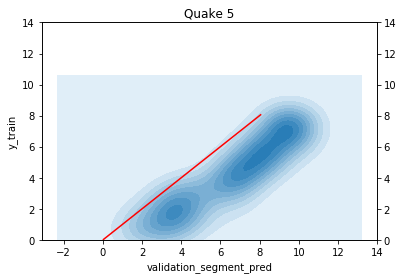

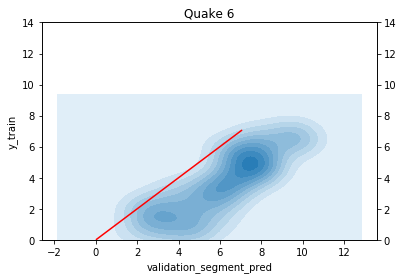

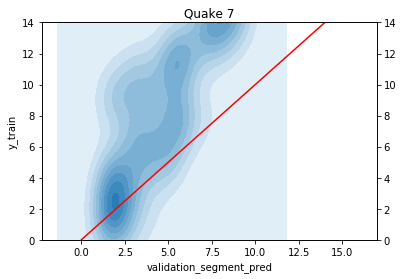

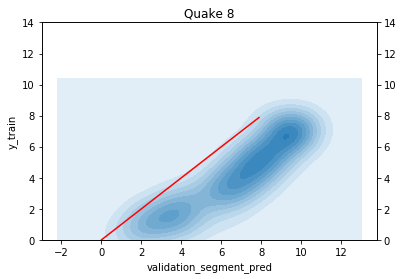

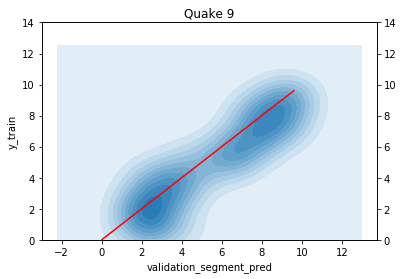

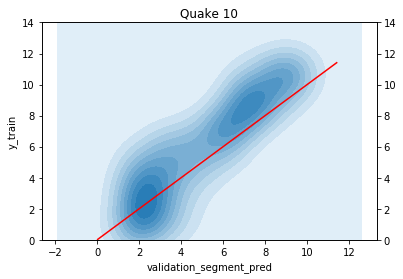

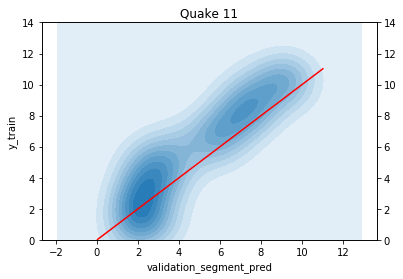

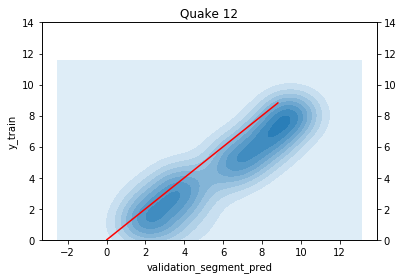

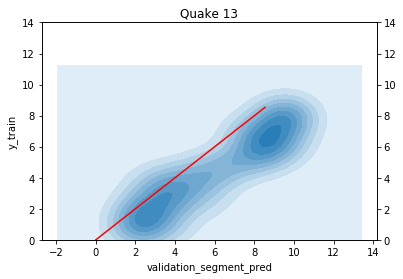

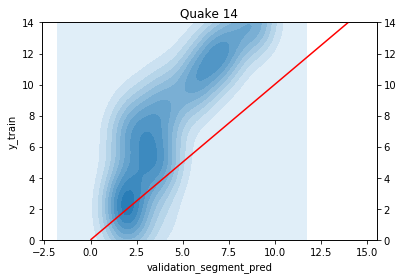

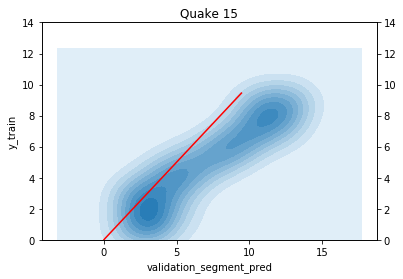

In [98]:
for i in range(1,16):
    sub_segment = segment_df.loc[quake_df.loc[i,'segment_idxes']]
    plt.figure(i)
    ax1 = sns.kdeplot(sub_segment['validation_segment_pred'], sub_segment['y_train'], shade=True)
    ax1.set_ylim(0,14)
    ax1.set_title('Quake {}'.format(i))
    
    ax2 = ax1.twinx()
    ax2.plot(sub_segment['y_train'],sub_segment['y_train'], color='r')
    ax2.set_ylim(0,14)
    
    plt.show()

There are no 'islands' on the KDE plot when using a 138 feature model.  The CatBoostRegressor hopelessly overfit the training set, although I didn't attempt to tune the hyperparameters.  RandomForests does not require much tuning, which is a very useful property when using a base model fitting to produce an analysis.